In [27]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import keras_tuner as kt

def load_dataset(folder_path):
    images = []
    types = []
    colors = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            name_part = filename.rsplit('.', 1)[0]
            type_and_color = name_part.split('_', 1)

            item_type = type_and_color[0].split()[-1].strip().lower()
            color = type_and_color[1].split()[-1].strip().lower()

            if color != "unknown":
                types.append(item_type)
                colors.append(color)

                img = Image.open(os.path.join(folder_path, filename)).resize((128, 128))
                images.append(np.array(img) / 255.0)

    return np.array(images), types, colors

def build_model(hp):
    input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
    
    initial_filters = hp.Int('initial_filters', min_value=16, max_value=64, step=16)
    x = tf.keras.layers.Conv2D(initial_filters, (3, 3), activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    n_conv_blocks = hp.Int('n_conv_blocks', 2, 4)
    for i in range(n_conv_blocks):
        filters = initial_filters * (2 ** i)
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    shared_features = tf.keras.layers.Flatten()(x)
    
    dense_units = hp.Int('dense_units', min_value=128, max_value=512, step=128)
    
    type_x = tf.keras.layers.Dense(dense_units, activation='relu')(shared_features)
    
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    type_x = tf.keras.layers.Dropout(dropout_rate)(type_x)
    type_output = tf.keras.layers.Dense(len(type_encoder[1]), activation='softmax', name='type_output')(type_x)
    
    color_x = tf.keras.layers.Dense(dense_units, activation='relu')(shared_features)
    color_x = tf.keras.layers.Dropout(dropout_rate)(color_x)
    color_output = tf.keras.layers.Dense(len(color_encoder[1]), activation='softmax', name='color_output')(color_x)
    
    model = tf.keras.models.Model(
        inputs=input_layer,
        outputs={'type_output': type_output, 'color_output': color_output}
    )
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'type_output': 'categorical_crossentropy',
            'color_output': 'categorical_crossentropy'
        },
        metrics={
            'type_output': 'accuracy',
            'color_output': 'accuracy'
        }
    )
    
    return model

aritzia_folder = 'aritzia_images'
ami_folder = 'ami_images'
maje_folder = 'maje_images'

aritzia_images, aritzia_types, aritzia_colors = load_dataset(aritzia_folder)
ami_images, ami_types, ami_colors = load_dataset(ami_folder)
maje_images, maje_types, maje_colors = load_dataset(maje_folder)

all_images = np.concatenate([aritzia_images, ami_images, maje_images], axis=0)
all_types = aritzia_types + ami_types + maje_types
all_colors = aritzia_colors + ami_colors + maje_colors

type_encoder = pd.factorize(pd.Series(all_types))
color_encoder = pd.factorize(pd.Series(all_colors))

type_labels = tf.keras.utils.to_categorical(type_encoder[0], num_classes=len(type_encoder[1]))
color_labels = tf.keras.utils.to_categorical(color_encoder[0], num_classes=len(color_encoder[1]))

X_train, X_val, y_type_train, y_type_val, y_color_train, y_color_val = train_test_split(
    all_images, type_labels, color_labels, test_size=0.2, random_state=42
)

tuner = kt.Hyperband(
    build_model,
    objective=[
        kt.Objective('val_type_output_accuracy', direction='max'),
        kt.Objective('val_color_output_accuracy', direction='max')
    ],
    max_epochs=20,
    directory='hyperparameter_tuning',
    project_name='clothing_classifier'
)

tuner.search_space_summary()

tuner.search(
    x=X_train,
    y={'type_output': y_type_train, 'color_output': y_color_train},
    validation_data=(X_val, {'type_output': y_type_val, 'color_output': y_color_val}),
    epochs=20,
    batch_size=32
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

history = best_model.fit(
    x=X_train,
    y={'type_output': y_type_train, 'color_output': y_color_train},
    validation_data=(X_val, {'type_output': y_type_val, 'color_output': y_color_val}),
    epochs=20,
    batch_size=32
)

best_model.save('best_clothing_classifier.keras')
print("\nBest model saved as 'best_clothing_classifier.keras'")

results = best_model.evaluate(
    X_val,
    {'type_output': y_type_val, 'color_output': y_color_val}
)

print("\nBest Model Evaluation Results:")
for metric, value in zip(best_model.metrics_names, results):
    print(f"{metric}: {value:.4f}")

Trial 30 Complete [00h 04m 44s]
multi_objective: -1.199999988079071

Best multi_objective So Far: -1.2314814925193787
Total elapsed time: 00h 33m 03s

Best Hyperparameters:
initial_filters: 64
n_conv_blocks: 2
dense_units: 512
dropout_rate: 0.4
learning_rate: 0.00016960331830446725
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 15s 209ms/step - color_output_accuracy: 0.2014 - color_output_loss: 4.3158 - loss: 8.1873 - type_output_accuracy: 0.1157 - type_output_loss: 3.8715 - val_color_output_accuracy: 0.2907 - val_color_output_loss: 3.3125 - val_loss: 6.4022 - val_type_output_accuracy: 0.2685 - val_type_output_loss: 3.0912
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - color_output_accuracy: 0.2683 - color_output_loss: 3.4499 - loss: 6.4053 - type_output_accuracy: 0.2799 - type_output_loss: 2.9552 - val_color_output_accuracy: 0.2907 - val_color_output_loss: 3.0431 - val_loss: 5.5809 - val_type_output_accuracy: 0.416

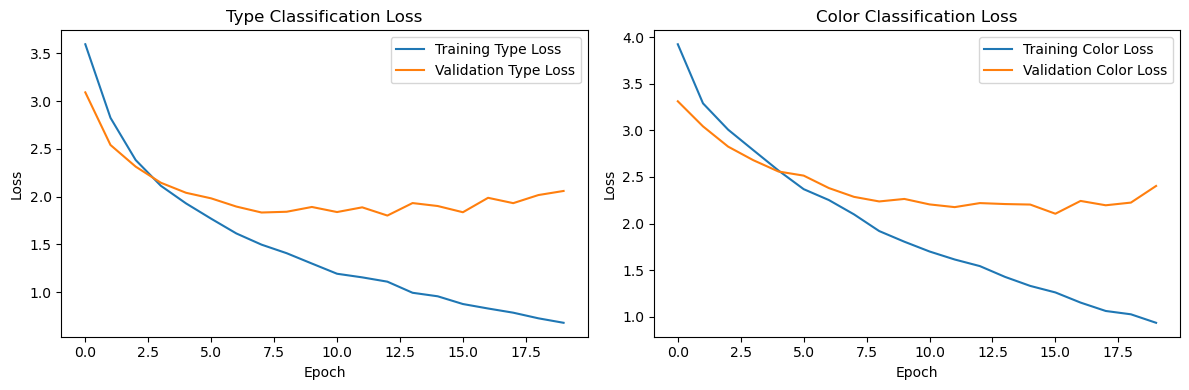

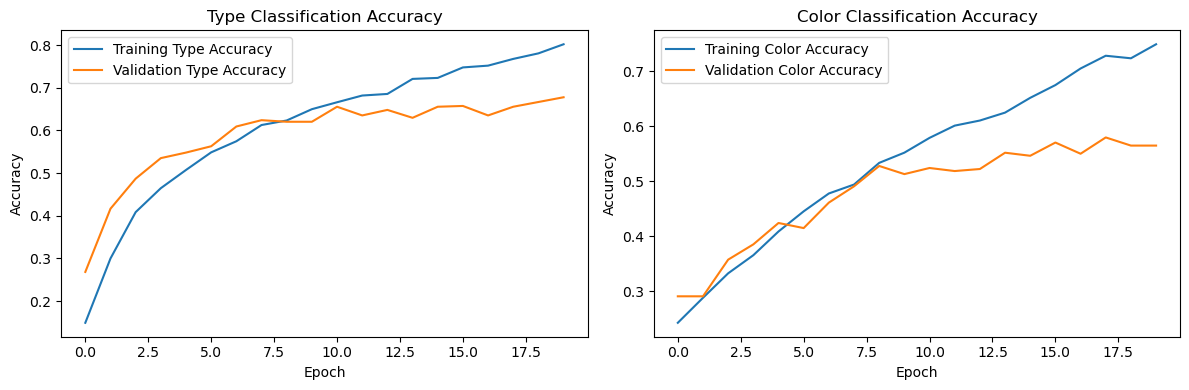

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['type_output_loss'], label='Training Type Loss')
plt.plot(history.history['val_type_output_loss'], label='Validation Type Loss')
plt.title('Type Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['color_output_loss'], label='Training Color Loss')
plt.plot(history.history['val_color_output_loss'], label='Validation Color Loss')
plt.title('Color Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['type_output_accuracy'], label='Training Type Accuracy')
plt.plot(history.history['val_type_output_accuracy'], label='Validation Type Accuracy')
plt.title('Type Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['color_output_accuracy'], label='Training Color Accuracy')
plt.plot(history.history['val_color_output_accuracy'], label='Validation Color Accuracy')
plt.title('Color Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()